In [ ]:
#https://stackoverflow.com/questions/35064304/runtimeerror-make-sure-the-graphviz-executables-are-on-your-systems-path-aft
#!pip install graphviz
#!conda install --yes -c conda-forge graphviz

# Minimal example to get `dask.distributed` working

* No `dask_geopandas` installed in `dask.distributed`...will have to ask Andrew. For now, test `dask.dataframe` only.
* Move all functions into this notebook to simplify for now.
* Read in multiple tabular datasets, merge, and do aggregation.
* Get task graph loaded (`bus_service_utils` has the `pip` and `conda` requirements)
* Can we test `dask.delayed` and `dask futures`?

In [1]:
import dask.dataframe as dd
import pandas as pd

from dask.distributed import Client

analysis_date = "2022-10-12"
RT_GCS = 'gs://calitp-analytics-data/data-analyses/rt_delay/cached_views/'

In [2]:
def import_data(itp_id, date):
    stop_times = dd.read_parquet(
                f"{RT_GCS}st_{itp_id}_{date}.parquet")
    trips = dd.read_parquet(
        f"{RT_GCS}trips_{itp_id}_{date}.parquet")
    
    return stop_times, trips

In [3]:
def categorize_time_of_day(value: int ) -> str:
    if isinstance(value, int):
        hour = value
    if hour < 4:
        return "Owl"
    elif hour < 7:
        return "Early AM"
    elif hour < 10:
        return "AM Peak"
    elif hour < 15:
        return "Midday"
    elif hour < 20:
        return "PM Peak"
    else:
        return "Evening"

In [22]:
def merge_stop_times_to_trips(stop_times: dd.DataFrame, 
                          trips: dd.DataFrame) -> dd.DataFrame:   
    shape_id_cols = ["calitp_itp_id", "shape_id"]

    merged = dd.merge(
        stop_times,
        trips[shape_id_cols + ["trip_id"]].drop_duplicates(),
        on = ["calitp_itp_id", "trip_id"]
    )
    
    # Map to time-of-day
    stop_times_binned = merged.assign(
        time_of_day=merged.apply(
            lambda x: categorize_time_of_day(x.departure_hour), axis=1, 
            meta=('time_of_day', 'str'))
    )
    
    # Calculate the number of arrivals by time-of-day
    arrivals = (stop_times_binned.groupby(shape_id_cols + ["time_of_day"])
          .agg({"stop_id": "count"})
            .reset_index()
         )
    
    return arrivals

In [5]:
# In the script, it's looping over list of operators,
# and importing just the operator's data, merging, and giving outputs.
def my_function(itp_id: int, analysis_date: str) -> dd.DataFrame:
    stop_times, trips = import_data(itp_id, analysis_date)   

    # Merge routelines to trips, and drop shape_ids that are 
    # giving the same info (in terms of route_length, direction_id)
    merged = merge_stop_times_to_trips(stop_times, trips)
    
    return merged

In [6]:
client = Client("dask-scheduler.dask.svc.cluster.local:8786")
client

/opt/conda/lib/python3.10/site-packages/distributed/client.py:1309: VersionMismatchWarning: Mismatched versions found

+-------------+----------------+----------------+----------------+
| Package     | client         | scheduler      | workers        |
+-------------+----------------+----------------+----------------+
| cloudpickle | 2.2.0          | 2.1.0          | 2.1.0          |
| dask        | 2022.9.2       | 2022.8.0       | 2022.8.0       |
| distributed | 2022.9.2       | 2022.8.0       | 2022.8.0       |
| numpy       | 1.23.3         | 1.23.1         | 1.23.1         |
| pandas      | 1.5.0          | 1.4.3          | 1.4.3          |
| python      | 3.10.6.final.0 | 3.8.13.final.0 | 3.8.13.final.0 |
+-------------+----------------+----------------+----------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


<Client: 'tcp://10.96.3.216:8786' processes=3 threads=6, memory=46.91 GiB>

Show task graph for just 1 operator.

* low-level: `.visualize()` 
* high-level: `.dask.visualize()`

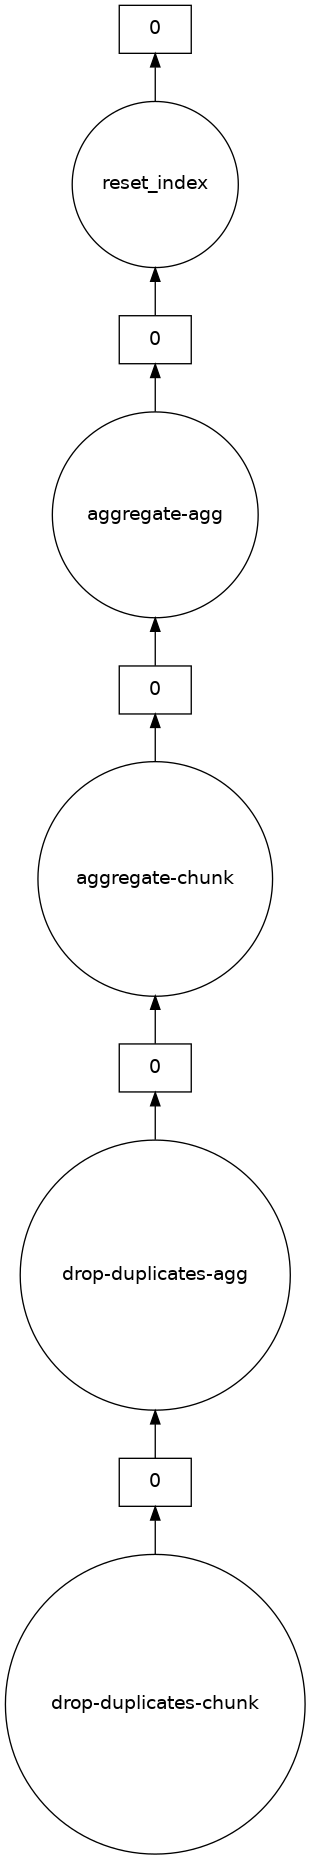

In [7]:
# Low-level graph
my_function(183, analysis_date).visualize(optimize_graph=True)

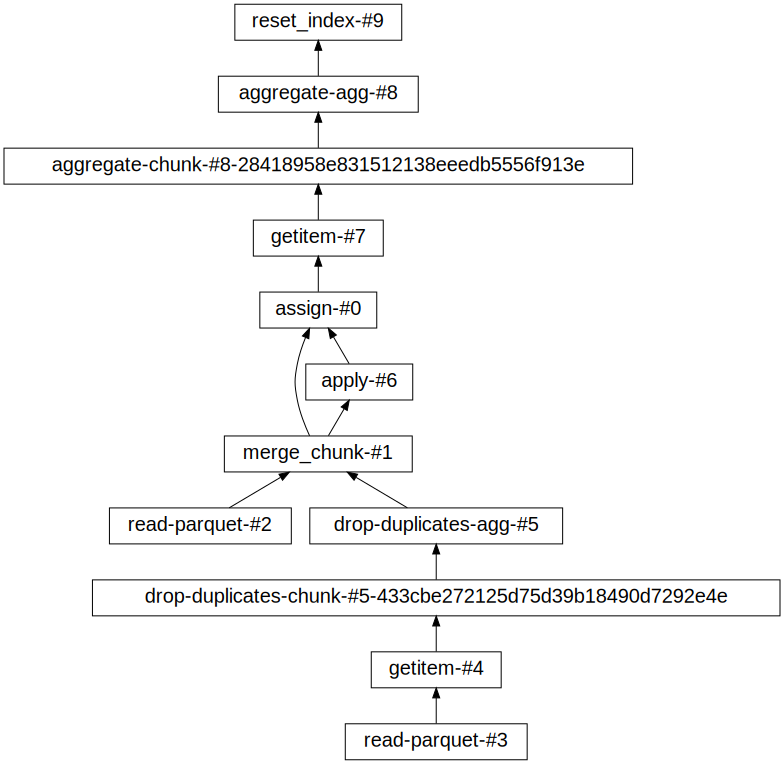

In [8]:
# high-level graph
my_function(183, analysis_date).dask.visualize()

In [10]:
def import_data_combined(date):
    RT_GCS = 'gs://calitp-analytics-data/data-analyses/rt_delay/compiled_cached_views/'
    stop_times = dd.read_parquet(f"{RT_GCS}st_{date}.parquet")
    trips = dd.read_parquet(f"{RT_GCS}trips_{date}.parquet")
    
    return stop_times, trips

In [19]:
all_stop_times, all_trips = import_data_combined(analysis_date)

In [21]:
all_stop_times = all_stop_times.repartition(npartitions=5)
all_trips = all_trips.repartition(npartitions=5)

In [23]:
merged = merge_stop_times_to_trips(all_stop_times, all_trips)

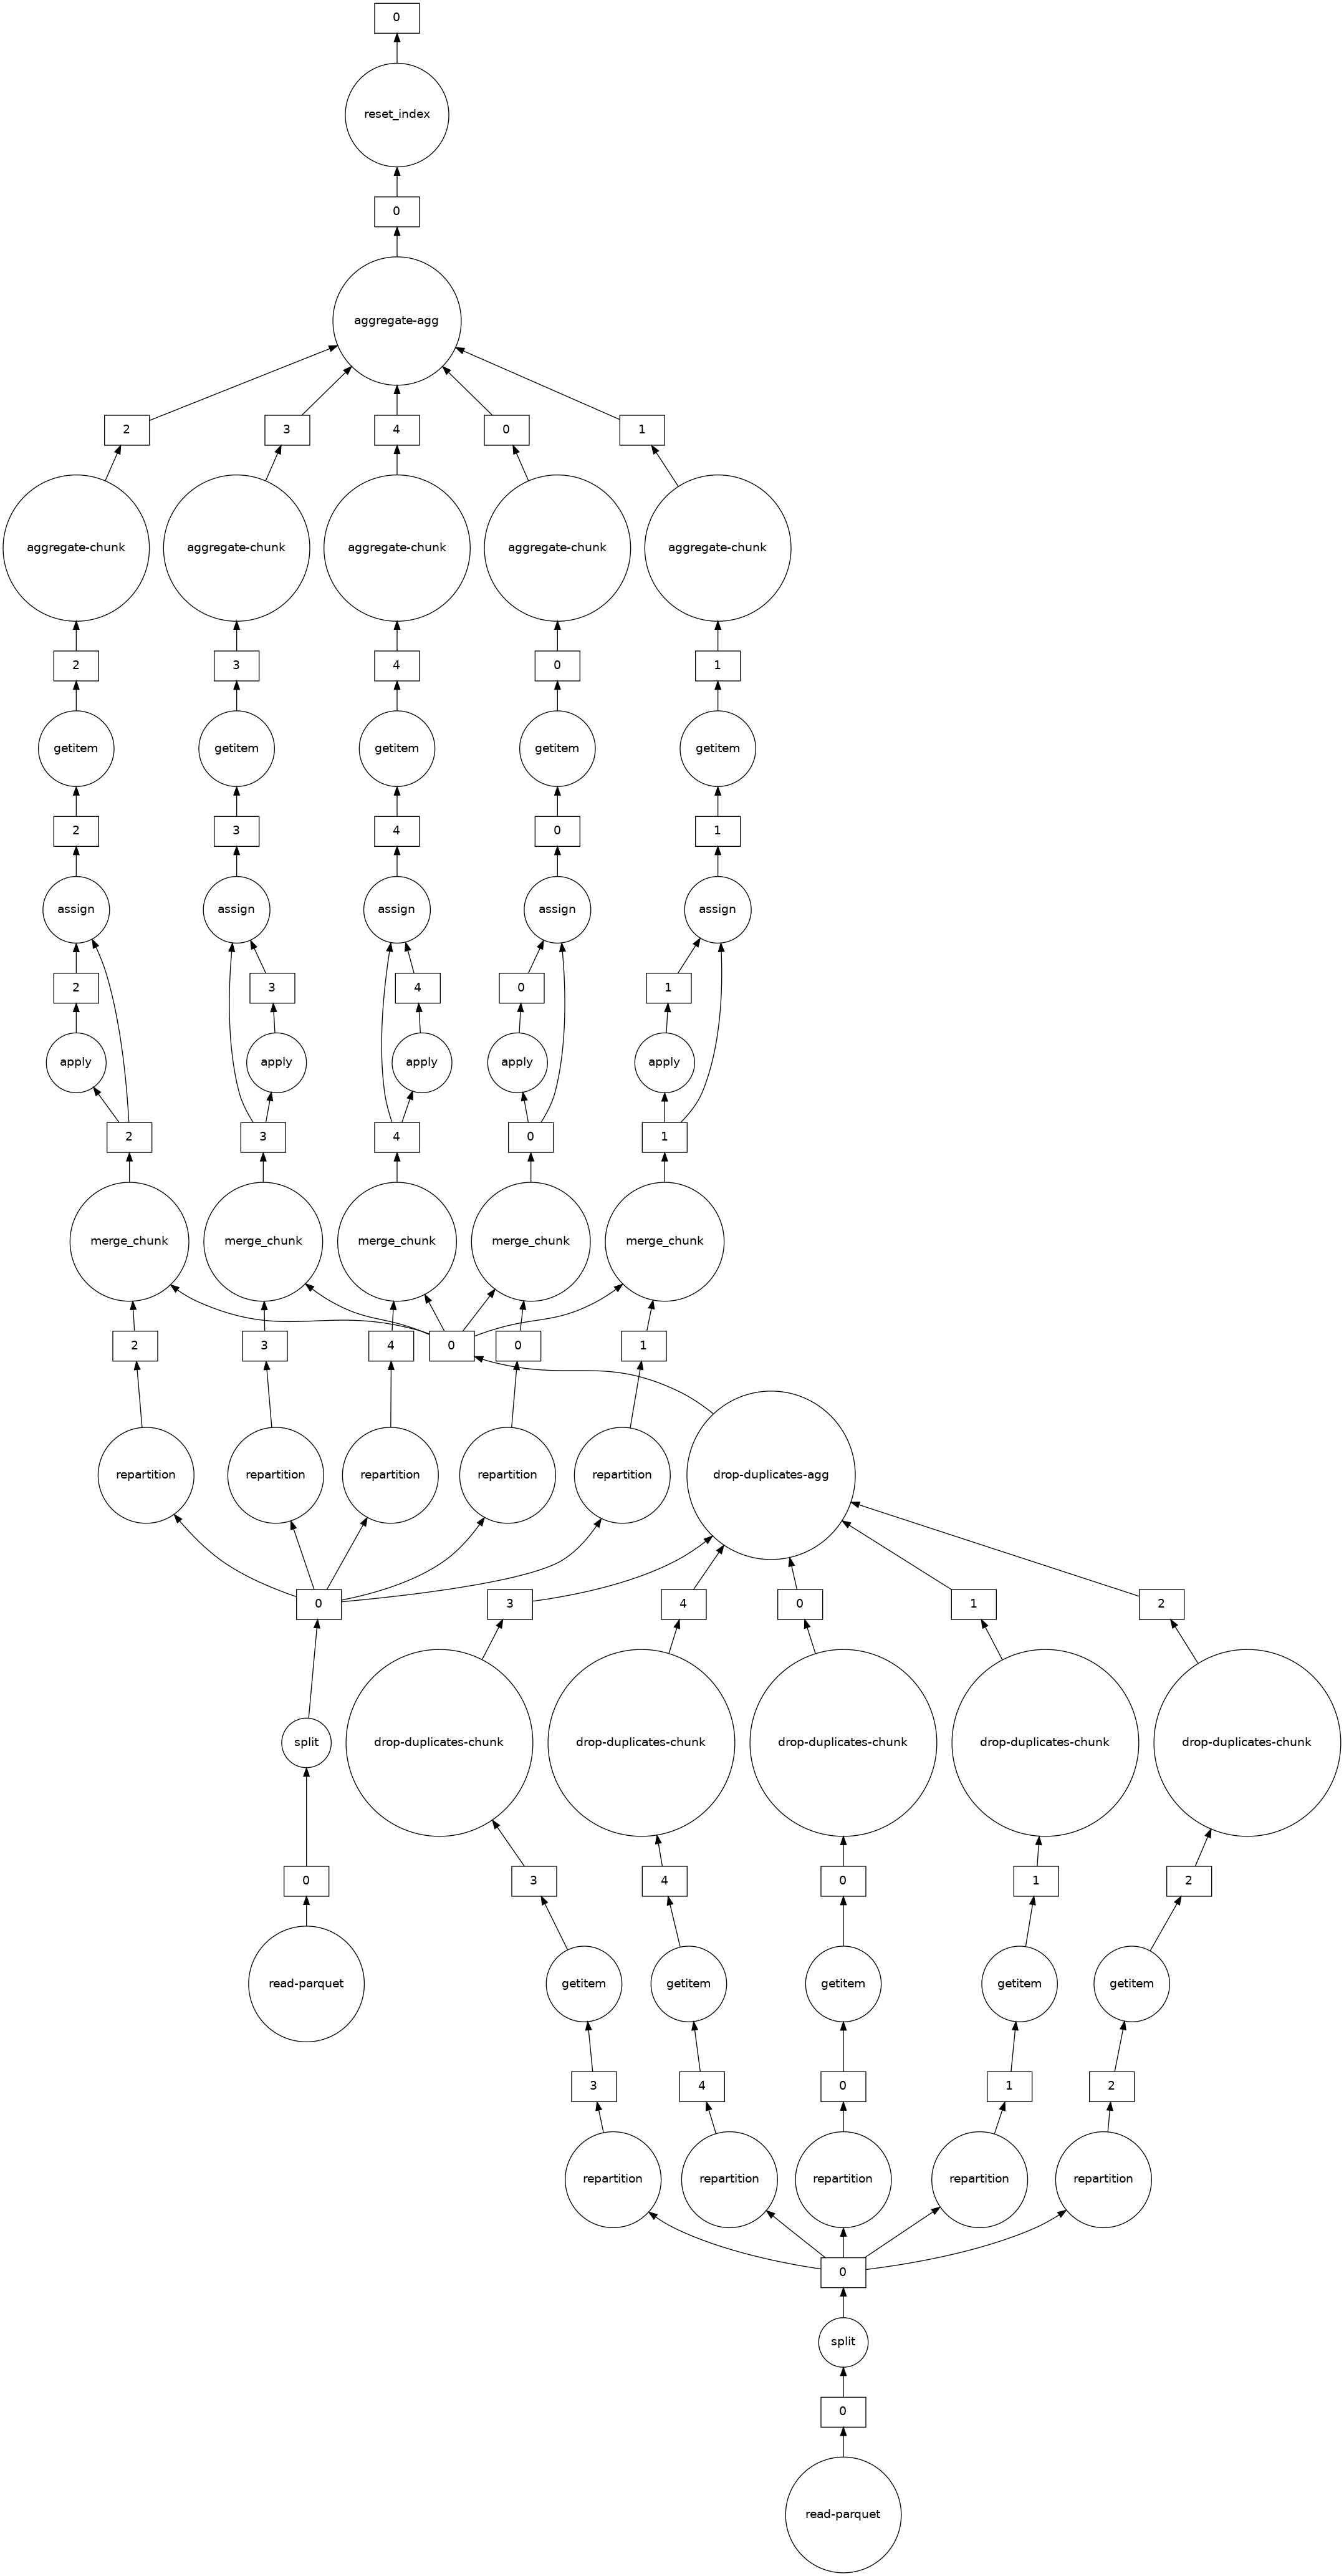

In [25]:
merged.visualize()

In [ ]:
#merged.calitp_itp_id.unique().compute()